In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
# from tqdm.auto import tqdm
# from scipy.signal import welch
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from qick.asm_v2 import AveragerProgramV2

In [3]:
from qick.rfboard import RFQickSocV2
soc = RFQickSocV2('/home/xilinx/jupyter_notebooks/fw/2025-01-03_111_tprocv2r21_rfbv2/qick_111_rfbv2.bit')
soccfg = soc

print(soccfg)

resetting clocks: 122.88 204.8
QICK running on ZCU111, software version 0.2.301

Firmware configuration (built Fri Jan  3 15:35:30 2025):

	Global clocks (MHz): tProcessor 384.000, RF reference 204.800

	8 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (10.667 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 0 is DAC228_T0_CH0 or RF board output 0
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (10.667 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 1 is DAC228_T0_CH1 or RF board output 1
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (5.333 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 2 is DAC228_T0_CH2 or RF board output 2
	3:	axis_signal_gen_v6 - envelope memory 32768 samples (5.333 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 3 is DAC228_T0_CH3 or RF boar

In [4]:
F_LO = 122.88*64
GEN_CH = 0
RO_CH = 0
RO_DC_CH = 2

In [5]:
soc.rfb_set_lo(F_LO, verbose=True)
# soc.rfb_set_lo(F_LO, ch=0, verbose=True) # ADCs
# soc.rfb_set_lo(F_LO, ch=1, verbose=True) # DACs 0-3
# soc.rfb_set_lo(F_LO, ch=2, verbose=True) # DACs 4-7

# as long as you're not saturating at any point in the chain (check with gain sweep), better to attenuate later
print("set attenuators:", soc.rfb_set_gen_rf(gen_ch=GEN_CH, att1=30, att2=31.75))
print("set attenuators:", soc.rfb_set_ro_rf(ro_ch=RO_CH, att=30))

  i |   f_vco  | DIV | MIN_N | DLY_SEL |   n  |   R  | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|----------|-----|-------|---------|------|------|-------|---------|----------|---------|------------
  0 |  7864.32 |   1 |    28 |       1 |   64 |    1 |     1 |  122.88 |  7864.32 |    0.00 | 6.4000e+01

Choosing solution 0 with minimal metric 64.
LO locked on attempt 1 after 0.01 sec
  i |   f_vco  | DIV | MIN_N | DLY_SEL |   n  |   R  | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|----------|-----|-------|---------|------|------|-------|---------|----------|---------|------------
  0 |  7864.32 |   1 |    28 |       1 |   64 |    1 |     1 |  122.88 |  7864.32 |    0.00 | 6.4000e+01

Choosing solution 0 with minimal metric 64.
LO locked on attempt 1 after 0.01 sec
  i |   f_vco  | DIV | MIN_N | DLY_SEL |   n  |   R  | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|----------|-----|-------|---------|------|------|-------|---------|----------|---------|-

In [136]:
import xrfdc

# 0x0000F000 is only used by DAC, I think
# 0x03000000 is not used?
# https://docs.amd.com/r/en-US/pg269-rf-data-converter/XRFdc_IntrEnable
# https://docs.amd.com/r/en-US/pg269-rf-data-converter/Interrupt-Handling
# https://github.com/Xilinx/embeddedsw/blob/master/XilinxProcessorIPLib/drivers/rfdc/src/xrfdc_hw.h

def clear_interrupts(soc, verbose=False):
    interrupt_masks = [
        (0x0000000F, "XRFDC_IXR_FIFOUSRDAT_MASK"), # FIFO over/underflow, linked to XRFDC_ADC_FIFO_OVR_MASK?
        (0x00000FF0, "XRFDC_ADC_IXR_DATAPATH_MASK"), # overflow/saturation in datapath (e.g. decimation), linked to XRFDC_ADC_DAT_OVR_MASK?
        (0x00FF0000, "XRFDC_SUBADC_IXR_DCDR_MASK"), # analog input over/under full-scale range for individual sub-ADCs, linked to OVR_RANGE interrupt
        (0x04000000, "XRFDC_ADC_OVR_VOLTAGE_MASK"), # analog input exceeding ADC safe range - gen3 RFSoC
        (0x08000000, "XRFDC_ADC_OVR_RANGE_MASK"), # analog input exceeding ADC full-scale range
        (0x10000000, "XRFDC_ADC_CMODE_OVR_MASK"), # analog input common-mode voltage above spec - gen3 RFSoC
        (0x20000000, "XRFDC_ADC_CMODE_UNDR_MASK"), # analog input common-mode voltage below spec - gen3 RFSoC
        (0x40000000, "XRFDC_ADC_DAT_OVR_MASK"),
        (0x80000000, "XRFDC_ADC_FIFO_OVR_MASK"),
    ]
    arr = xrfdc._ffi.new("unsigned int [1]")
    allclear = False
    attempts = 0
    maxattempts = 5
    while not allclear:
        allclear = True
        for name, cfg in soc['adcs'].items():
            tile, block = cfg['index']
            status = xrfdc._lib.XRFdc_GetIntrStatus(soc.rf._instance, xrfdc._lib.XRFDC_ADC_TILE,tile,block,arr)
            if status != 0: print("error in reading interrupts:", status)
            interrupts = arr[0]
            if interrupts != 0:
                allclear = False
                names = []
                for mask, name in interrupt_masks:
                    if (mask & interrupts) != 0:
                        interrupts &= 0xFFFFFFFF - mask
                        names.append(name)
                if interrupts != 0: print("unrecognized interrupts:", interrupts)
                if verbose or attempts == 0:
                    print("pass %d, interrupts on tile %d block %d:"%(attempts, tile, block), hex(arr[0]), names)
                status = xrfdc._lib.XRFdc_IntrClr(soc.rf._instance, xrfdc._lib.XRFDC_ADC_TILE,tile,block,0xffffffff)
                if status != 0: print("error in clearing interrupts:", status)
        attempts += 1
        if attempts >= maxattempts:
            print("giving up")
            break
    if attempts > 1 and attempts < maxattempts:
        print("successfully cleared all interrupts in %d attempts"%(attempts-1))

  0%|          | 0/1 [00:00<?, ?it/s]

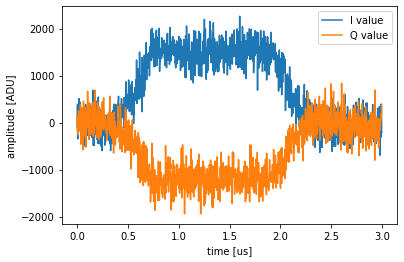

In [145]:
class LoopbackProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro",
                               freq=cfg['freq'],
                               gen_ch=gen_ch,
                               outsel='product')
        self.add_cosine(ch=gen_ch, name="ramp", length=cfg['ramp_len'], even_length=True)
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch,
#                        style="const",
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'],
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'],
                      )
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
    def _body(self, cfg):
        self.delay_auto()
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0.0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], mr=True)

config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': 1500,
          'nqz': 1,
          'trig_time': 0.0,
          'ro_len': 3.0,
          'flat_len': 1.0,
          'ramp_len': 1.0,
          'phase': 0,
          'gain': 1.0
         }
prog = LoopbackProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
# Set attenuator on DAC.
soc.rfb_set_gen_rf(config['gen_ch'], 25, 30)
# Set attenuator on ADC.
soc.rfb_set_ro_rf(config['ro_ch'], 30)

iq_list = prog.acquire_decimated(soc, soft_avgs=1)
clear_interrupts(soc)

t = prog.get_time_axis(ro_index=0)
iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");


set gain: 5


  0%|          | 0/1 [00:00<?, ?it/s]

read gain: 5


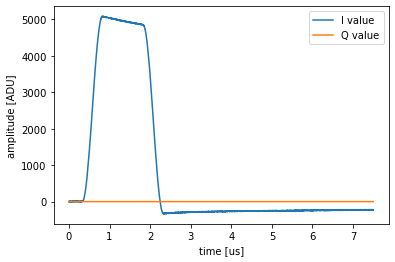

In [53]:
config = {'gen_ch': GEN_CH,
          'ro_ch': RO_DC_CH,
          'freq': 0,
          'nqz': 1,
          'trig_time': 0.0,
          'ro_len': 7.5,
          'flat_len': 1.0,
          'ramp_len': 1.0,
          'phase': 0,
          'gain': 1.0
         }
prog = LoopbackProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
soc.rfb_set_gen_dc(config['gen_ch'])
print("set gain:", soc.rfb_set_ro_dc(config['ro_ch'], 5))
iq_list = prog.acquire_decimated(soc, soft_avgs=1)
clear_interrupts(soc)

t = prog.get_time_axis(ro_index=0)
iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");
print("read gain:", soc.adc_chains[4].get_gain())

In [8]:
print("read bias:", soc.rfb_get_bias(0))
print("set bias:", soc.rfb_set_bias(0, 1))
print("read bias:", soc.rfb_get_bias(0))

read bias: 3.8147118175402284e-05
set bias: 1.0000267029827228
read bias: 1.0000267029827228


In [119]:
from scipy.signal import welch
# from numpy.fft import fftshift
from matplotlib import colors
from tqdm.auto import tqdm
def fold_freqs(fs, target_f, freqs):
    nqz = 1+np.floor(2*freqs/fs)
    sign = (-1)**(1 + nqz%2)
    folded_freqs = (sign*freqs) % (fs/2)
    
    target_nqz = 1+np.floor(2*target_f/fs)
    target_sign = (-1)**(1 + target_nqz%2)
    return ((target_nqz)//2)*fs + target_sign*folded_freqs
class ToneProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro",
                               freq=0)
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch,
                       style="const",
                       freq=cfg['freq'],
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'],
                       mode='periodic'
                      )
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        
    def _body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0.0)
        self.delay_auto()
        self.trigger(mr=True, t=1.0)

def tone_scan(center_freq, delta_freq):
    config = {'gen_ch': GEN_CH,
              'ro_ch': RO_CH,
              'freq': center_freq,
              'nqz': 1,
              'trig_time': 0.0,
              'ro_len': 3.0,
              'flat_len': 1.0,
              'phase': 0,
              'gain': 0.5
             }

    fs_adc = soc['readouts'][RO_CH]['fs']
    fs_dac = soc['gens'][GEN_CH]['fs']

    tone_freqs = np.linspace(center_freq-delta_freq, center_freq+delta_freq, 41)
    psd_2d = []
    for tone_freq in tqdm(tone_freqs):
        config['freq'] = tone_freq
        prog = ToneProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
        soc.arm_mr(ch=config['ro_ch'])
        iq_list = prog.run_rounds(soc, rounds=1, progress=False)
        soc.reset_gens()
#         print(tone_freq)
        clear_interrupts(soc)

        iq = soc.get_mr()
        complex_iq = iq.dot([1,1j])

        fft_freqs, psd = welch(iq[:,0], fs_adc, return_onesided=True, detrend=False, nperseg=128)
        psd_2d.append(psd)
#     plt.plot(iq[:200,0])
    return fs_dac, fs_adc, tone_freqs, fft_freqs, np.array(psd_2d)

In [114]:
soc.rfb_set_lo(F_LO, verbose=True)
# soc.rfb_set_lo(122.88*62, verbose=True)

  i |   f_vco  | DIV | MIN_N | DLY_SEL |   n  |   R  | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|----------|-----|-------|---------|------|------|-------|---------|----------|---------|------------
  0 |  7864.32 |   1 |    28 |       1 |   64 |    1 |     1 |  122.88 |  7864.32 |    0.00 | 6.4000e+01

Choosing solution 0 with minimal metric 64.
LO locked on attempt 1 after 0.00 sec
  i |   f_vco  | DIV | MIN_N | DLY_SEL |   n  |   R  | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|----------|-----|-------|---------|------|------|-------|---------|----------|---------|------------
  0 |  7864.32 |   1 |    28 |       1 |   64 |    1 |     1 |  122.88 |  7864.32 |    0.00 | 6.4000e+01

Choosing solution 0 with minimal metric 64.
LO locked on attempt 1 after 0.00 sec
  i |   f_vco  | DIV | MIN_N | DLY_SEL |   n  |   R  | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|----------|-----|-------|---------|------|------|-------|---------|----------|---------|-

  0%|          | 0/41 [00:00<?, ?it/s]

(0.0, 2048.0)

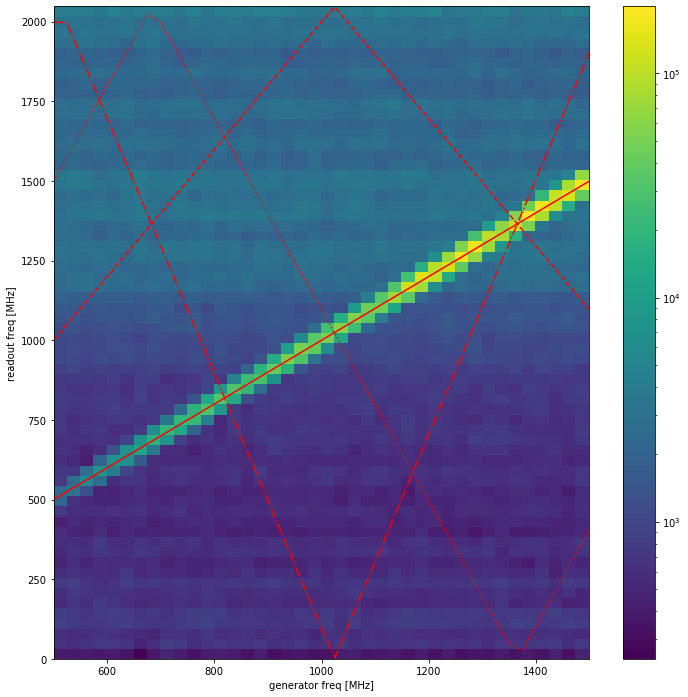

In [120]:
soc.rfb_set_gen_rf(GEN_CH, 30, 30)
soc.rfb_set_ro_rf(RO_CH, 30)

fs_dac, fs_adc, tone_freqs, fft_freqs, psd_2d = tone_scan(center_freq=1000, delta_freq=500)
fig, ax = plt.subplots(figsize=(12,12))
plt.colorbar(ax.pcolormesh(tone_freqs, fft_freqs, psd_2d.T, norm=colors.LogNorm()), ax=ax)
ax.set_ylabel("readout freq [MHz]")
ax.set_xlabel("generator freq [MHz]");
plt.plot(tone_freqs, fold_freqs(fs_adc, 0, tone_freqs), color='red', linestyle='solid', label='blah')
plt.plot(tone_freqs, fold_freqs(fs_adc, 0, 2*tone_freqs), color='red', linestyle='dashed')
plt.plot(tone_freqs, fold_freqs(fs_adc, 0, 3*tone_freqs), color='red', linestyle='dotted')
plt.plot(tone_freqs, fold_freqs(fs_adc, 0, 4*tone_freqs), color='red', linestyle='dashdot')

# ax.legend()
ax.set_ylim((fft_freqs[0], fft_freqs[-1]))

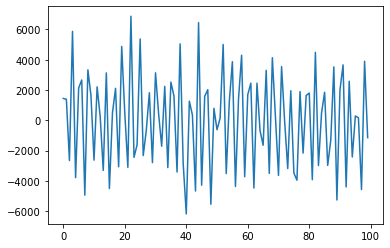

In [65]:
# plt.plot(iq[:100,0])